In [83]:
from keras import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Dense, TimeDistributed
import matplotlib.dates as mdates

In [2]:
import utils
import autoregression as ar
import neural_network as nn

In [3]:
# Setting up pyplot runtime configuration

from matplotlib.ticker import MaxNLocator

SMALL = 14
MEDIUM = 16
LARGE = 20
THICK = 4
THIN = 3
WIDE_FIG = (20,7.5)
TWO_TIMES_TWO = (20,15)
SMALL_FIG = (6,6)
OPACITY = .25


plt.style.context('fivethirtyeight')
plt.rc('axes', facecolor='#E6E6E6', edgecolor='black', axisbelow=True, grid=True)
plt.rc('grid', color='white', linestyle='solid')
plt.rc('lines', linewidth=THIN)

plt.rc('font', size=SMALL, weight='bold')          # default text sizes
plt.rc('axes', titlesize=MEDIUM)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM)    # legend fontsize
plt.rc('figure', titlesize=LARGE)  # fontsize of the figure title

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [42]:
temperatureX = utils.parse_file('data/pcu1/Supply trafo B winding 2U temp.csv', 'tempX')
temperatureY = utils.parse_file('data/pcu1/Supply trafo B winding 2V temp.csv', 'tempY')
temperatureZ = utils.parse_file('data/pcu1/Supply trafo B winding 2W temp.csv', 'tempZ')
auxiliaries = utils.parse_file('data/pcu1/AUX ON from PCU.csv', 'aux_on')
current = utils.parse_file('data/pt2/i1.csv', 'I')

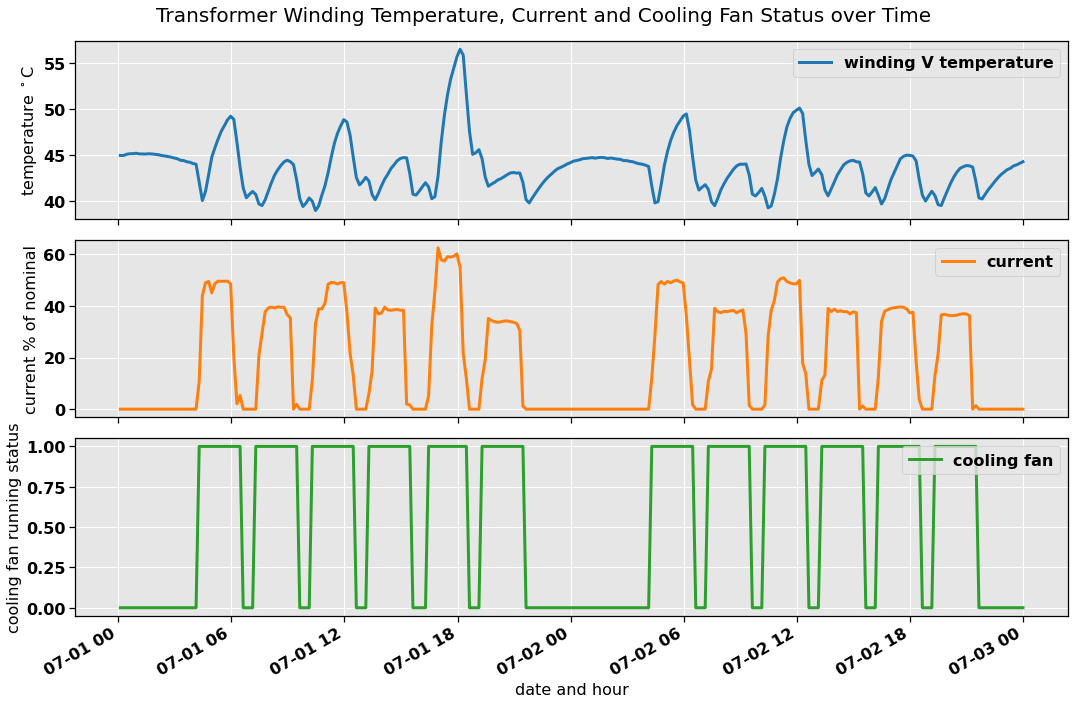

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,10), sharex=True)
fig.suptitle('Transformer Winding Temperature, Current and Cooling Fan Status over Time', fontsize=LARGE)

temp_name = 'tempY'
operation = utils.align(auxiliaries, current, temperatureY)
start='2018-07-01 00:00:00'
end='2018-07-03 00:00:00'

ax = axes[0]
operation[temp_name][start:end].plot(ax=ax, label='winding V temperature')
ax.set_ylabel('temperature $^\circ$C')
ax.legend(loc='upper right')

ax = axes[1]
(operation['I'] / 630 * 100)[start:end].plot(ax=ax, color=COLORS[1], label='current')
ax.set_ylabel('current % of nominal')
ax.legend(loc='upper right')

ax = axes[2]
operation['aux_on'][start:end].plot(ax=ax, color=COLORS[2], label='cooling fan')
ax.set_ylabel('cooling fan running status')
ax.set_xlabel('date and hour')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

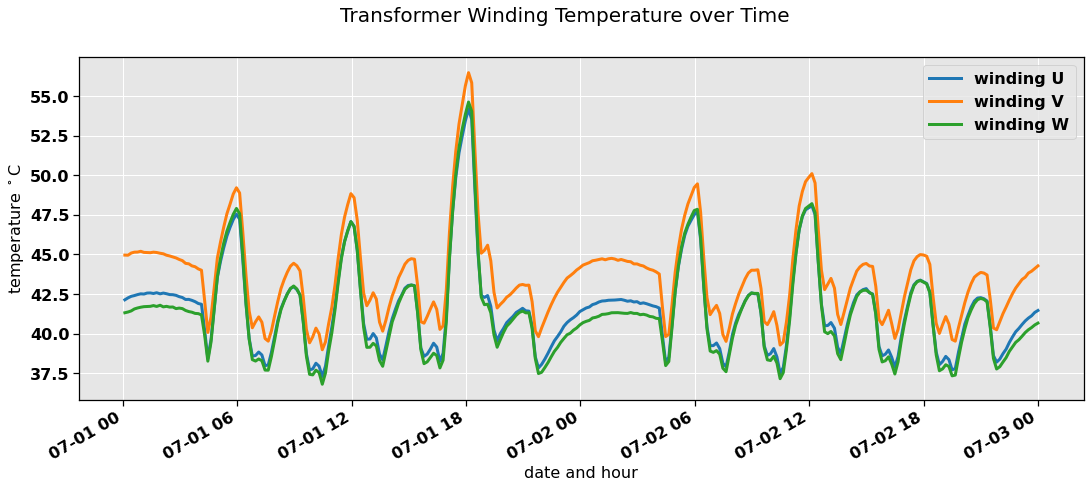

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18,7))
fig.suptitle('Transformer Winding Temperature over Time', fontsize=LARGE)

start='2018-07-01 00:00:00'
end='2018-07-03 00:00:00'

ax = axes
temperatureX[start:end].plot(ax=ax)
temperatureY[start:end].plot(ax=ax)
temperatureZ[start:end].plot(ax=ax)
ax.set_xlabel('date and hour')
ax.set_ylabel('temperature $^\circ$C')
ax.legend(['winding U', 'winding V', 'winding W'])

plt.show()

In [46]:
X, y = ar.prep_current_model_dataset(auxiliaries, current, temperatureX, 8)
X.head(0)

,aux_on,intercept,I,I2,temp__1,temp__2,temp__3,temp__4,temp__5,temp__6,temp__7,temp__8


In [122]:
X, y = ar.prep_current_temp_model_dataset(auxiliaries, current, temperatureX, temperatureY, temperatureZ, 0)
X.head(1)

,aux_on,intercept,I,I2,tempY,tempZ
2018-06-04 12:20:00,1.0,1.0,176.699997,31222.888922,42.623032,40.858322


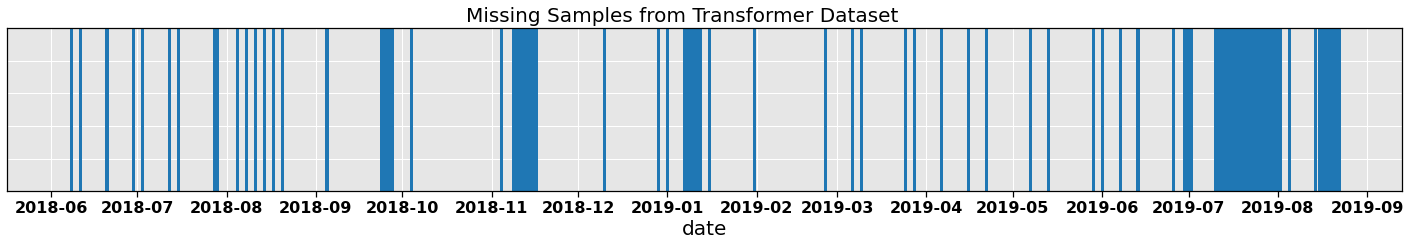

In [82]:
T = utils.sample_gaps(X)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,3))
fig.suptitle('Missing Samples from Transformer Dataset', fontsize=LARGE)

ax = axes
ax.eventplot(T.index, orientation='horizontal')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_ylim(.6,.7)
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.set_xlabel('date', fontsize=LARGE)

plt.show()

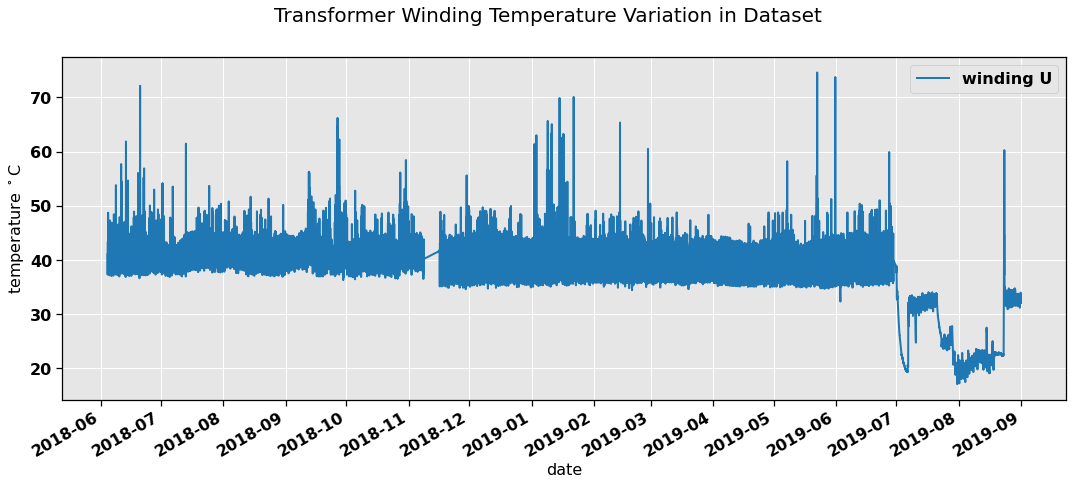

In [135]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18,7))
fig.suptitle('Transformer Winding Temperature Variation in Dataset', fontsize=LARGE)

ax = axes
temperatureX.plot(ax=ax, lw=2, label=None)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_ylabel('temperature $^\circ$C')
ax.legend(['winding U'])
ax.set_xlabel('date')

plt.show()

R2=0.998, MSE=2.240e-02


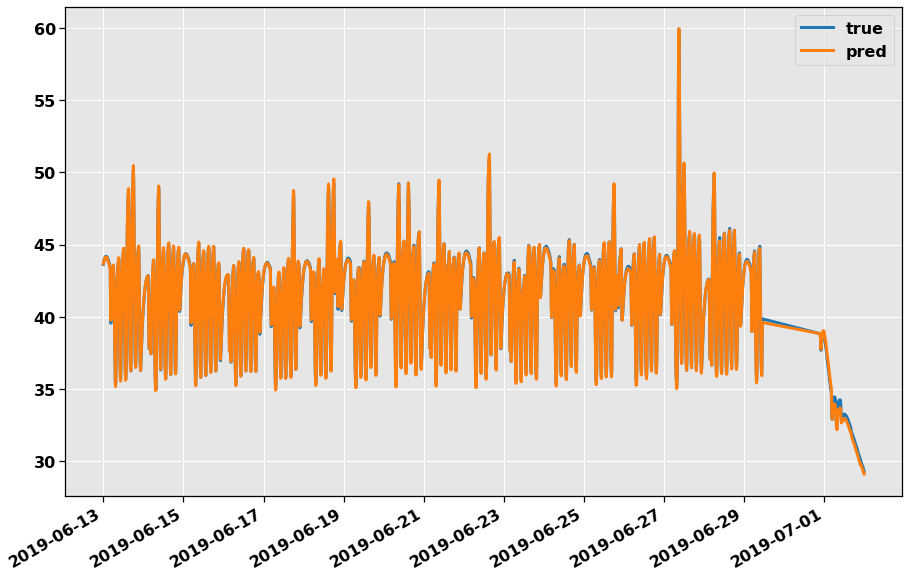

,aux_on,intercept,I,I2,tempY,tempZ
0,-0.076356,0.614782,0.001318,-0.000003,0.358623,0.615028


In [124]:
start = None
end = '2018-08-01 00:00:00'
X_train, y_train = X[start:end].copy(), y[start:end].copy()

start='2019-06-13 00:00:00'
end='2019-07-02 00:00:00'

#start='2018-07-05 00:00:00'
#end='2018-07-15 00:00:00'
X_test, y_test = X[start:end].copy(), y[start:end].copy()

#X_train, X_test = ar.scale(X_train, X_test, cols=['I', 'I2', 'tempX', 'tempY', 'temp__1'])

coeffs = ar.ols(X_train, y_train)

t0 = y_test['tempX'][0]
y_pred = ar.evaluate(coeffs, X_test, t0)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
ax = axes

y_test.plot(ax=ax)
y_pred.plot(ax=ax)

r2 = skl.metrics.r2_score(y_test, y_pred)
mse = skl.metrics.mean_squared_error(y_test, y_pred)
print(f'R2={r2:.3f}, MSE={mse:.3e}')

ax.legend(['true', 'pred'])
plt.show()
coeffs

<AxesSubplot:>

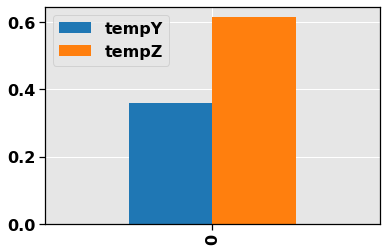

In [125]:
abs(coeffs).iloc[:,4:].plot.bar()

In [89]:
def reshape(X, y, batch_size):
    n, p = X.shape
    features = np.empty((n-batch_size, batch_size, p))
    targets = np.empty((n-batch_size, batch_size, 1))
    for i in range(n-batch_size):
        features[i,:,:] = X[i:i+batch_size,:]
        targets[i,:,0] = y[i:i+batch_size,0]
    return features, targets

def reshape2(X, y, batch_size):
    n, p = X.shape
    features = np.empty((n-batch_size, batch_size, p))
    targets = np.empty((n-batch_size, 1, 1))
    for i in range(n-batch_size):
        features[i,:,:] = X[i:i+batch_size,:]
        targets[i,0,0] = y[i+batch_size,0]
    return features, targets

In [90]:
X, y = nn.prep_current_model_dataset(auxiliaries, current, temperatureX)

In [115]:
start=None
end='2018-08-01 00:00:00'
X_train, y_train = X[start:end].to_numpy().copy(), y[start:end].to_numpy().copy()
n, p = X_train.shape

start='2019-06-13 00:00:00'
end='2019-07-01 00:00:00'

#start='2018-07-05 00:00:00'
#end='2018-07-15 00:00:00'

X_test, y_test = X[start:end].to_numpy().copy(), y[start:end].to_numpy().copy()
X_train.shape, X_test.shape

((8165, 3), (2362, 3))

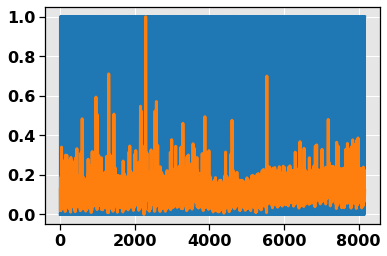

In [117]:
scaler = skl.preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:,0] = X_train[:,0]
X_test_scaled[:,0] = X_test[:,0]

ymin, ymax = y_train.min(), y_train.max()
scaler.fit(y_train)
y_train_scaled = scaler.transform(y_train)
y_test_scaled = scaler.transform(y_test)

scaler.fit(y_train_scaled)
y_train_scaled = scaler.transform(y_train_scaled)
y_test_scaled = scaler.transform(y_test_scaled)

plt.plot(X_train_scaled[:,1])
plt.plot(y_train_scaled[:,0])
plt.show()

In [119]:
sample_size = 6
X_train_reshaped, y_train_reshaped = reshape(X_train_scaled, y_train_scaled, sample_size)
X_test_reshaped, y_test_reshaped = reshape(X_test_scaled, y_test_scaled, sample_size)

In [106]:
model = Sequential([
    LSTM(30, return_sequences=True, input_shape=(sample_size, p), dropout=.0, recurrent_dropout=.3, unroll=True),
    LSTM(18, return_sequences=True, unroll=True),
    Dense(sample_size)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 6, 30)             4080      
_________________________________________________________________
lstm_11 (LSTM)               (None, 6, 18)             3528      
_________________________________________________________________
dense_5 (Dense)              (None, 6, 6)              114       
Total params: 7,722
Trainable params: 7,722
Non-trainable params: 0
_________________________________________________________________


In [113]:
epochs = 1
batch_size = 50
model.fit(X_train_reshaped, y_train_reshaped, epochs=epochs, batch_size=batch_size, shuffle=False, verbose=True)

164/164 [==============================] - 3s 18ms/step - loss: 0.0028


R2=0.848, MSE=1.559e+00


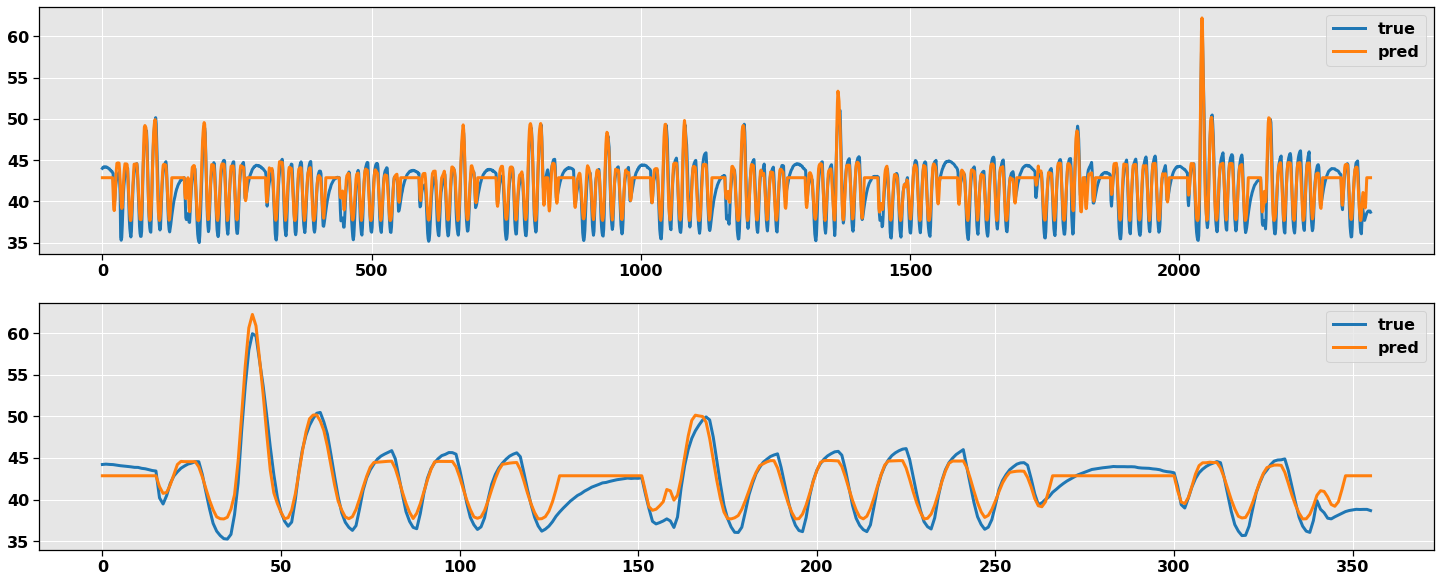

In [121]:
y_pred_raw = model.predict(X_test_reshaped)
y_pred = y_pred_raw[:,-1,0].reshape(-1,1)
y_pred = y_pred*(ymax - ymin) + ymin
shift = 1
y_true = y_test[sample_size-shift:-1*shift if shift else None]

r2 = skl.metrics.r2_score(y_true, y_pred)
mse = skl.metrics.mean_squared_error(y_true, y_pred)
print(f'R2={r2:.3f}, MSE={mse:.3e}')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(25,10))
ax = axes[0]
ax.plot(y_true)
ax.plot(y_pred)
ax.legend(['true', 'pred'])

ax = axes[1]
start, end = 2000, None
ax.plot(y_true[start:end])
ax.plot(y_pred[start:end])
ax.legend(['true', 'pred'])

plt.show()